In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
input_data = pd.read_csv("taxi_data_20190101_121000.csv",index_col=0)
interzonal_dist = pd.read_csv("interzonal.csv")

In [5]:
input_data.columns

input_data.head()

,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,st_distance
0,93377,2019-01-01 12:10:03,2019-01-01 12:31:42,1,138,151,6251.343710
1,93890,2019-01-01 12:10:08,2019-01-01 12:55:59,1,161,138,6864.909138
2,88297,2019-01-01 12:10:08,2019-01-01 12:35:24,1,138,163,6699.423654
3,92953,2019-01-01 12:10:23,2019-01-01 12:37:29,1,230,138,7437.864494
4,91843,2019-01-01 12:10:23,2019-01-01 12:34:14,2,138,65,10985.603338


In [6]:
interzonal_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
0,0.000000,25166.444726,30195.322922,14377.864831,11734.665196,10099.141865,19208.294026,20544.626999,30235.589427,29385.659502,...,30121.847859,15702.083557,15441.028623,14796.384033,24006.640529,31412.601130,19946.113856,11496.524843,18456.011165,18191.377145
1,25166.444726,0.000000,24188.702603,13471.295905,25507.187452,14789.493729,13787.102440,16454.696984,11181.975353,3539.435190,...,25863.644482,11979.333947,11107.494071,8489.974273,4594.753561,27612.262517,11101.138752,14745.717424,16874.663209,17296.747815
2,30195.322922,24188.702603,0.000000,17531.522557,42350.879222,32523.333282,10784.744194,9942.170649,10334.497026,19068.051272,...,0.000000,16965.842430,17819.373218,24223.420904,17484.387840,1687.323571,11000.949983,20733.624579,10941.182459,11146.819010
3,14377.864831,13471.295905,17531.522557,0.000000,23833.351957,14035.425643,4720.831201,6672.981043,14769.398349,14691.643564,...,18201.108718,521.406921,579.289049,6336.214161,9253.302741,20321.789248,4471.481121,2370.031810,5203.756127,5226.773131
4,11734.665196,25507.187452,42350.879222,23833.351957,0.000000,7960.449341,29658.621130,31552.602791,37261.896120,33374.912695,...,42812.589861,24384.818574,23540.950196,18774.987549,29076.838575,44673.052310,28347.412095,20622.040298,29853.362093,29785.491256


In [8]:
input_data_filter = input_data[input_data['PULocationID'] == 138]

input_data_filter.head()

,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,st_distance
0,93377,2019-01-01 12:10:03,2019-01-01 12:31:42,1,138,151,6251.343710
2,88297,2019-01-01 12:10:08,2019-01-01 12:35:24,1,138,163,6699.423654
4,91843,2019-01-01 12:10:23,2019-01-01 12:34:14,2,138,65,10985.603338
5,88389,2019-01-01 12:10:24,2019-01-01 12:25:21,1,138,229,5932.704211
6,96031,2019-01-01 12:10:34,2019-01-01 12:46:22,1,138,149,17445.294615


In [9]:
input_data_filter

,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,st_distance
0,93377,2019-01-01 12:10:03,2019-01-01 12:31:42,1,138,151,6251.343710
2,88297,2019-01-01 12:10:08,2019-01-01 12:35:24,1,138,163,6699.423654
4,91843,2019-01-01 12:10:23,2019-01-01 12:34:14,2,138,65,10985.603338
5,88389,2019-01-01 12:10:24,2019-01-01 12:25:21,1,138,229,5932.704211
6,96031,2019-01-01 12:10:34,2019-01-01 12:46:22,1,138,149,17445.294615
8,90539,2019-01-01 12:10:54,2019-01-01 12:33:51,1,138,90,9029.843605
10,88304,2019-01-01 12:11:10,2019-01-01 12:32:02,1,138,163,6699.423654
11,89963,2019-01-01 12:11:11,2019-01-01 12:29:36,1,138,65,10985.603338
12,90644,2019-01-01 12:11:19,2019-01-01 12:25:22,1,138,82,1759.065096
13,95345,2019-01-01 12:11:28,2019-01-01 12:31:52,2,138,224,8103.149955


In [10]:
input_data_filter.reset_index(drop=True)

,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID,st_distance
0,93377,2019-01-01 12:10:03,2019-01-01 12:31:42,1,138,151,6251.343710
1,88297,2019-01-01 12:10:08,2019-01-01 12:35:24,1,138,163,6699.423654
2,91843,2019-01-01 12:10:23,2019-01-01 12:34:14,2,138,65,10985.603338
3,88389,2019-01-01 12:10:24,2019-01-01 12:25:21,1,138,229,5932.704211
4,96031,2019-01-01 12:10:34,2019-01-01 12:46:22,1,138,149,17445.294615
5,90539,2019-01-01 12:10:54,2019-01-01 12:33:51,1,138,90,9029.843605
6,88304,2019-01-01 12:11:10,2019-01-01 12:32:02,1,138,163,6699.423654
7,89963,2019-01-01 12:11:11,2019-01-01 12:29:36,1,138,65,10985.603338
8,90644,2019-01-01 12:11:19,2019-01-01 12:25:22,1,138,82,1759.065096
9,95345,2019-01-01 12:11:28,2019-01-01 12:31:52,2,138,224,8103.149955


1) The netwrokx graph node definition:

In [11]:
class PassengerRequest:
    def __init__(self, trip):
        #We should many other columns for analysis purpose
        self.pickup_location = trip.PULocationID
        self.dropoff_location = trip.DOLocationID
        self.ride_distance = trip.st_distance

2) Create the request nodes:

In [14]:
pool_graph = nx.Graph()
for index, row in input_data_filter.iterrows():
    pool_graph.add_node(PassengerRequest(row))
pool_graph.graph

{}

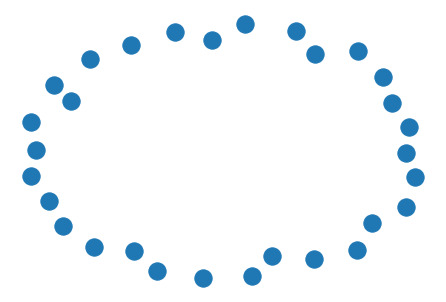

In [18]:
nx.draw(pool_graph)

In [19]:
pool_graph.number_of_nodes()

30

3) Adding the edges between nodes and calculating 
In our case from the airport to the respective zones we have two cases:

Pickup(P1,P2)->Drop P1 -> Drop P2

Pickup(P2,P1)-> Drop P2 -> Drop P1


In [ ]:
def calculate_edge_weights(node1,node2):
    
    
    